/var/folders/nr/fsdjxt490mg3r9b88wh_nnph0000gn/T/ipykernel_37703/1945365521.py:48: RuntimeWarning: overflow encountered in scalar subtract
  differences = [abs(p1 - p2) for p1, p2 in pairs]


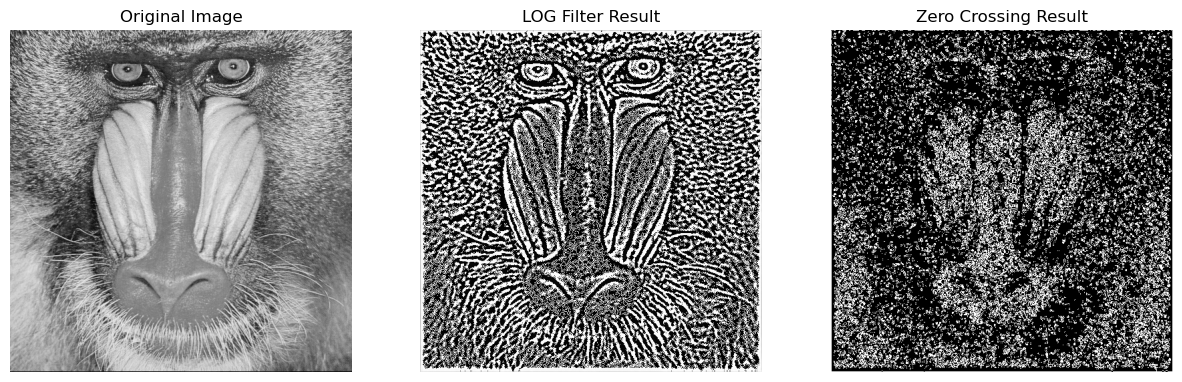

[[0. 1. 0. ... 1. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian_kernel(size, sigma=1):
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma**2)) * np.exp(-((x - (size-1)/2)**2 + (y - (size-1)/2)**2) / (2 * sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

def apply_filter(image, kernel):
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2
    padded_image = np.pad(image, pad_size, mode='constant')
    filtered_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            filtered_image[i, j] = np.sum(region * kernel)
    
    return filtered_image

def log_filter(image, sigma=1):
    size = int(2 * np.ceil(3 * sigma) + 1)
    gaussian = gaussian_kernel(size, sigma)
    laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    smooth_image = apply_filter(image, gaussian)
    log_image = apply_filter(smooth_image, laplacian)
    return log_image

def zero_crossing(image, threshold=0):
    zc_image = np.zeros(image.shape)
    padded_image = np.pad(image, 1, mode='constant')
    
    for i in range(1, padded_image.shape[0] - 1):
        for j in range(1, padded_image.shape[1] - 1):
            region = padded_image[i-1:i+2, j-1:j+2]
            center_pixel = region[1, 1]
            pairs = [
                (region[1, 0], region[1, 2]),  # 동-서
                (region[0, 1], region[2, 1]),  # 남-북
                (region[0, 0], region[2, 2]),  # 북동-남서
                (region[0, 2], region[2, 0])   # 북서-남동
            ]

            differences = [abs(p1 - p2) for p1, p2 in pairs]
            max_diff = max(differences)
            
            sign_changes = sum(np.sign(p1) != np.sign(p2) for p1, p2 in pairs)

            if sign_changes >= 2 and max_diff > threshold:
                zc_image[i-1, j-1] = 1
    
    return zc_image

# 이미지를 불러오기
image_path = './image/babbon.bmp' 
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# LOG 필터 적용
log_image = log_filter(image, sigma=2)

# 영교차 검출
zc_image = zero_crossing(log_image, threshold=100)

# 결과 출력
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(log_image, cmap='gray')
axs[1].set_title("LOG Filter Result")
axs[1].axis('off')

axs[2].imshow(zc_image, cmap='gray')
axs[2].set_title("Zero Crossing Result")
axs[2].axis('off')

plt.show()

print(zc_image)
